<a href="https://colab.research.google.com/github/satyamnewale/basic-NLP/blob/main/nn-using-GPU-.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

Saving fashion-mnist_test.csv to fashion-mnist_test.csv


In [2]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [3]:
torch.manual_seed(42)

In [4]:
df = pd.read_csv('fashion-mnist_test.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


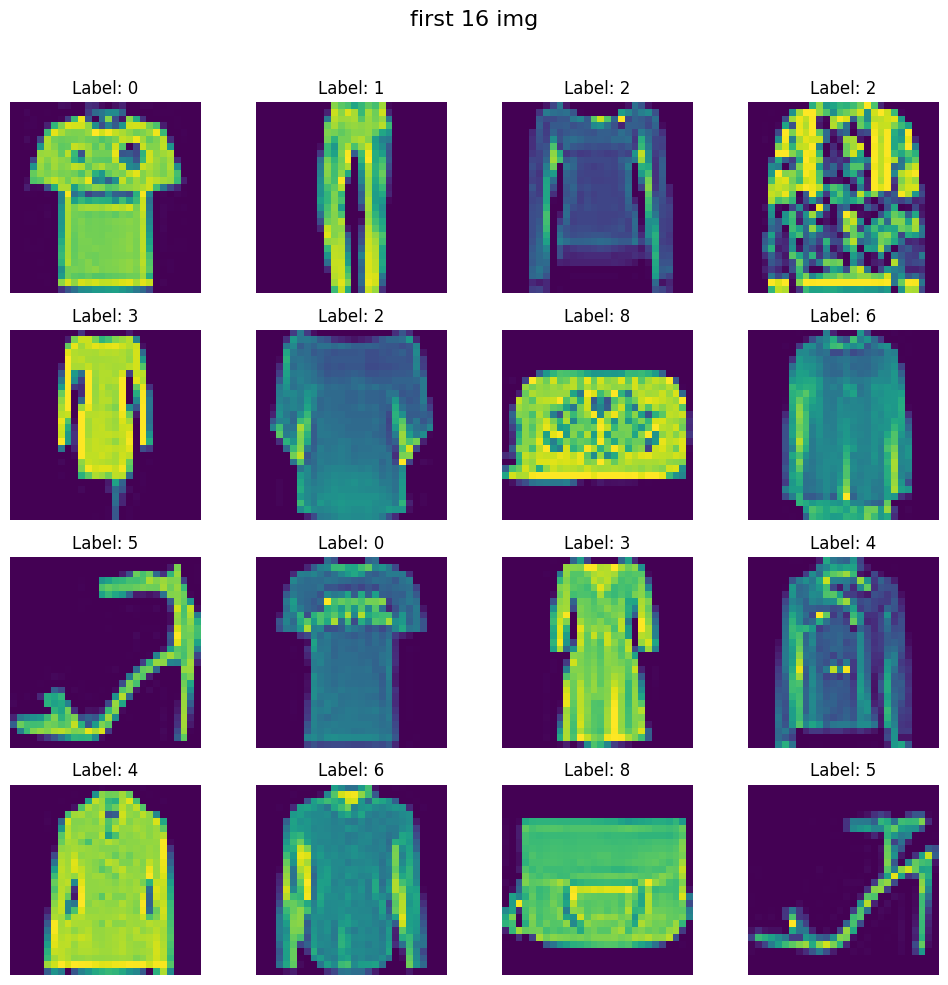

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("first 16 img",fontsize= 16)

for i, ax in enumerate(axes.flat):
  img = df.iloc[i, 1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f"Label: {df.iloc[i, 0]}")

plt.tight_layout(rect= [0, 0, 1, 0.96] )
plt.show()


In [6]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state= 42)

In [27]:
#scaling the features
X_train = X_train/255.0
X_test = X_test/255.0

In [29]:
#tensor conversion
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train).long()
y_test_tensor = torch.from_numpy(y_test).long()


In [30]:
#check for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device.type}")

using device: cuda


In [31]:
#customDataset class

class customDataset(Dataset):

  def __init__(self, features, labels):
    self.features = features
    self.labels = labels

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    return self.features[idx], self.labels[idx]

In [32]:
#create train_dataset object
train_dataset = customDataset(X_train_tensor, y_train_tensor)
test_dataset = customDataset(X_test_tensor, y_test_tensor)

In [76]:
#create batches
train_loader = DataLoader(train_dataset, batch_size= 64, shuffle= True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size= 64, shuffle= False, pin_memory=True)

In [77]:
#create nn class

class Model(nn.Module):

  def __init__(self,num_features):

    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(p = 0.3),

        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(p = 0.3),

        nn.Linear(64, 10)
    )

  def forward(self, x):
      return self.model(x)

In [78]:
epoch = 201
learning_rate = 0.01

In [79]:
#initialising the model
model = Model(X_train_tensor.shape[1])
model.to(device)
#loss function
criteria = nn.CrossEntropyLoss()

#optimizer
optimizer = optim.Adam(model.parameters(), lr= learning_rate, weight_decay = 1e-4)


In [80]:
#training loop

for epoch in range(epoch):
  epoch_loss = 0
  for batch_features, batch_labels in train_loader:
   batch_features = batch_features.to(device)
   batch_labels = batch_labels.to(device)
   #forward pass
   output = model(batch_features)

   #calculate loss
   loss = criteria(output, batch_labels)

   #backward pass
   optimizer.zero_grad()
   loss.backward()

   #update grads
   optimizer.step()

   epoch_loss += loss.item()

  if epoch % 20 == 0:
    print(f"epoch: {epoch}, loss: {epoch_loss/len(train_loader)}")


epoch: 0, loss: 0.7978421137332916
epoch: 20, loss: 0.42889649271965025
epoch: 40, loss: 0.40647996759414673
epoch: 60, loss: 0.3935523915290833
epoch: 80, loss: 0.40797756564617155
epoch: 100, loss: 0.3932454038858414
epoch: 120, loss: 0.393509512424469
epoch: 140, loss: 0.3834975185394287
epoch: 160, loss: 0.3849362587928772
epoch: 180, loss: 0.38010506391525267
epoch: 200, loss: 0.39342146122455596


In [81]:
loss.item()

0.46136951446533203

In [82]:
#evolution
model.eval()

Model(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [84]:
#evolution code
total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in train_loader:

    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    output = model(batch_features)
    _, predicted = torch.max(output, 1)

    total += batch_labels.shape[0]
    correct += (predicted == batch_labels).sum().item()

print(f"accuracy: {correct/total}")

accuracy: 0.90975


In [57]:
torch.cuda.is_available()

True